In [1]:
# sklearn 패키지로부터 import tree 
from sklearn import tree

import numpy as np
import pandas as pd

from sklearn.tree import export_graphviz # export_graphviz: 그래프 저장용 텍스트 파일 포맷인 .dot 파일을 만듦

In [2]:
# 트리 시각화를 위한 모듈 import
!pip install pydot
!pip install graphviz

import pydot
import graphviz
from IPython.core.display import Image 

In [3]:
df = pd.read_csv("diabetes.csv")

In [4]:
# classification tree 구축
clf = tree.DecisionTreeClassifier() # tree 객체에서 DecisionTreeClassifier()를 불러와서 clf에 저장

In [5]:
# 함수로 만듦
def draw_decision_tree(clf):
    dot_data = export_graphviz(clf, out_file = None, 
                                
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

In [6]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
x = df[["Pregnancies","Glucose","BloodPressure","SkinThickness","Insulin",
        "BMI","DiabetesPedigreeFunction","Age"]]

In [8]:
y = df[["Outcome"]]

In [9]:
# test와 train 분리하기
from sklearn.model_selection import train_test_split

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [10]:
clf = clf.fit(x_train, y_train)

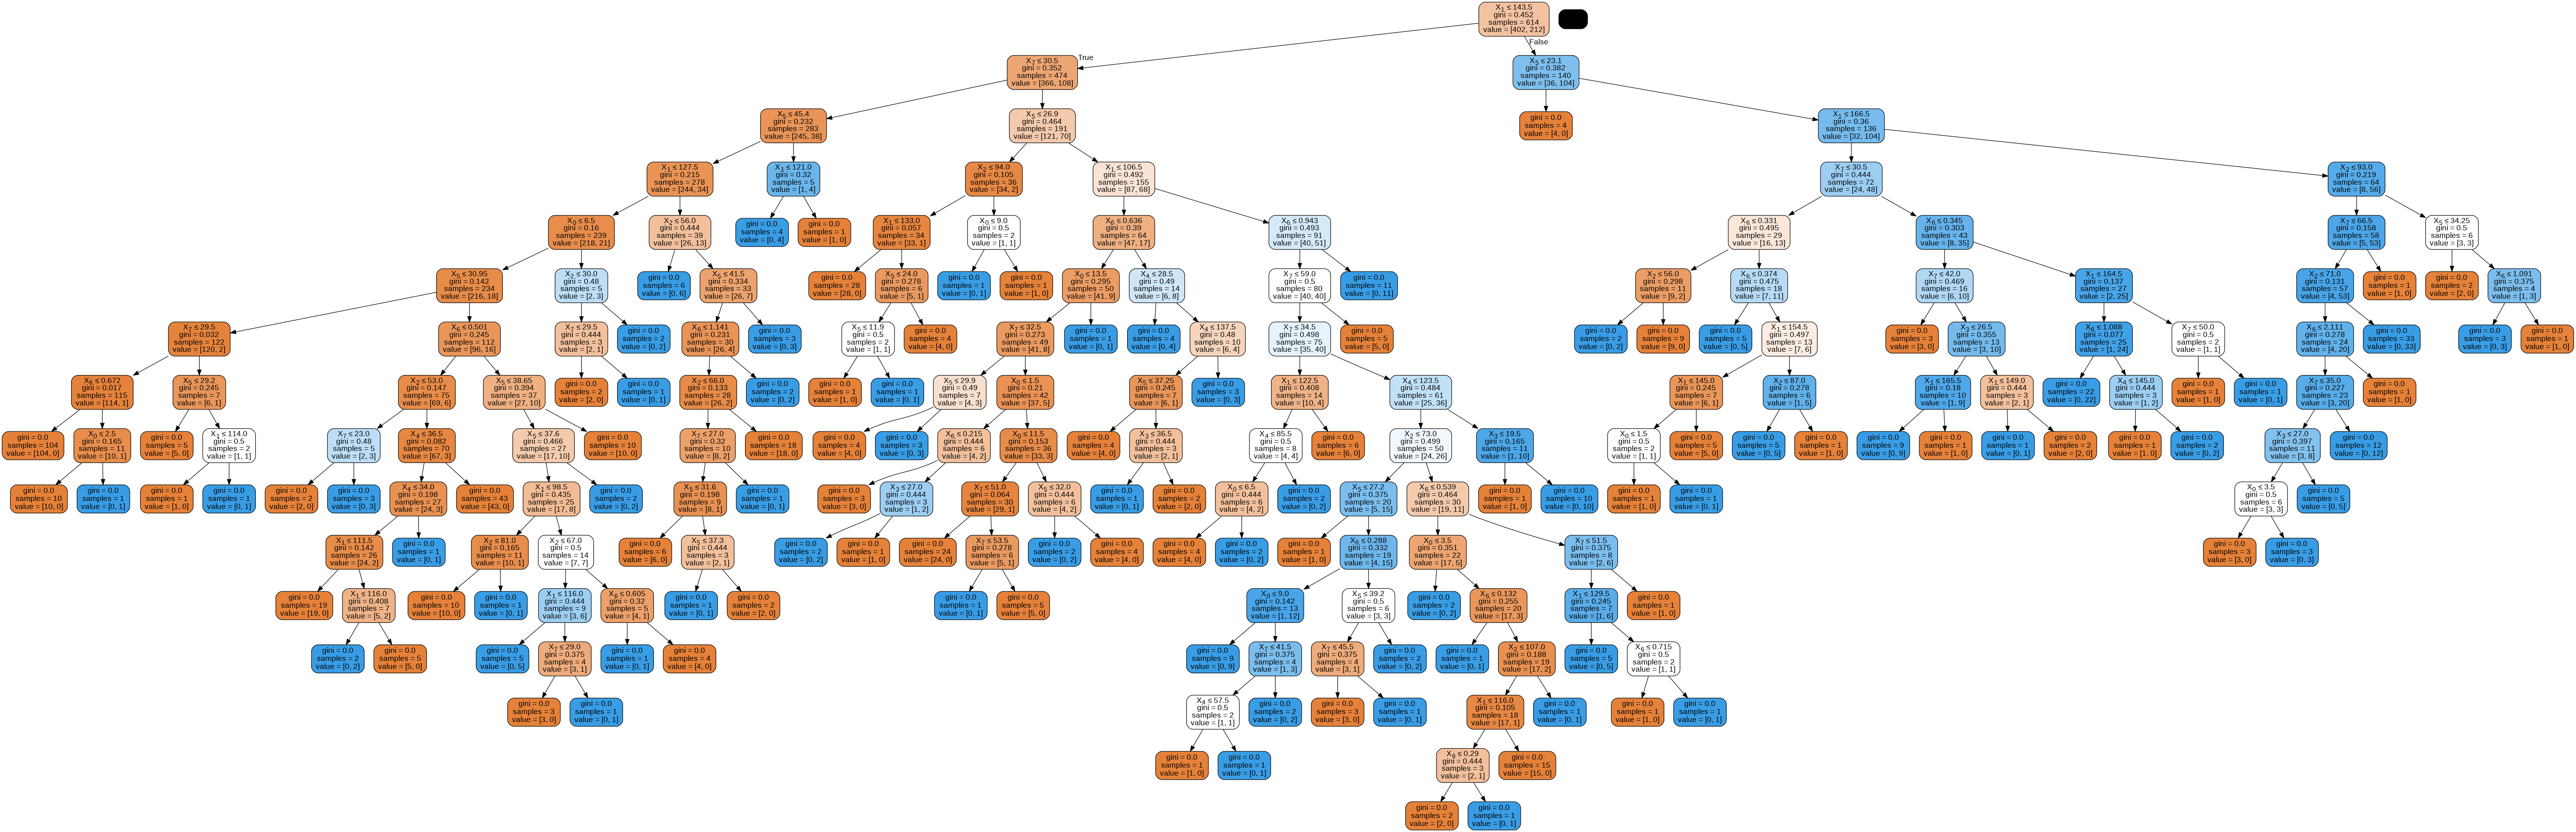

In [11]:
draw_decision_tree(clf)



In [12]:
from sklearn.metrics import accuracy_score
# before pruning
y_pred = clf.predict(x_test)
accuracy_score(y_test, y_pred)

0.7012987012987013

In [13]:
from sklearn.model_selection import GridSearchCV # 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법

# GridSearch는 확인하고 싶은 다양한 파라미터값을 넣어주면
# 그것들을 하나씩 확인하면서 스코어를 내고 가장 좋은 성능의 모델에 대한 결과를 확인하고 사용할 수 있음

In [24]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
# max_depth 와 min_samples_split라는 parameter에 대해 범위 지정
hyperparamters = {'max_depth': list(range(2, 20)),  'min_samples_split': list(range(2, 200))}

# GridSearch 진행
GridCV = GridSearchCV(estimator=df, param_grid=hyperparamters, cv=5, verbose=1)

GridCV.fit(x_train, y_train)
GridCV.best_params_ # 가장 좋은 성능을 보였을 때의 parameter

TypeError: ignored

In [16]:
import matplotlib.pyplot as plt

In [17]:
clf = tree.DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(x_train, y_train)

# effective alphas, corresponding total leaf impurities 구하기
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

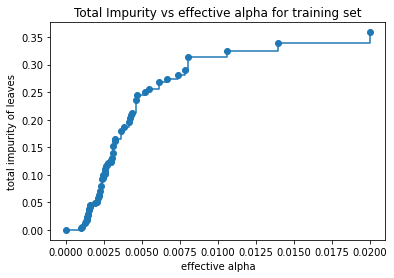

In [18]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()
# plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
# axes: 좌표평면을 나타내는 변수

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

In [20]:
# effective alpha 값에 대응하는 sub-trees 시각화

clfs = []
count = 0
for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf = clf.fit(x_train, y_train)
    count += 1
    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
      count, clf.tree_.node_count, ccp_alpha))
    display(draw_decision_tree(clf))
    clfs.append(clf)
    print("====================================================================================")

# ccp_alpha = 0 일 때는 not-pruned full tree
# ccp_alpha를 0부터 시작해서 크기를 늘려감, effective alpha를 지나면 가지치기
# 마지막에는 root node만 남음
# alpha에 따라서 subtree의 크기를 조정할 수 있음을 확인

Output hidden; open in https://colab.research.google.com to view.

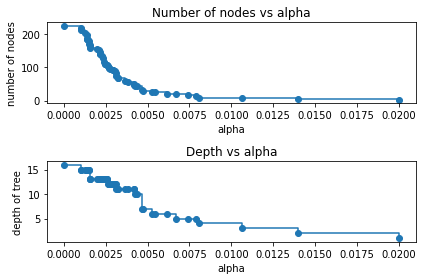

In [21]:
# alpha값에 따른 node 수의 트리의 깊이

# 노드가 하나뿐인 마지막 tree는 제외
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

# tree의 node 수
node_counts = [clf.tree_.node_count for clf in clfs]

# tree의 depth
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2, 1)
# Number of nodes vs alpha
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
# Depth vs alpha
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

# alpha 값이 커지면 트리는 작아지므로, node의 수와 트리의 깊이도 작아짐

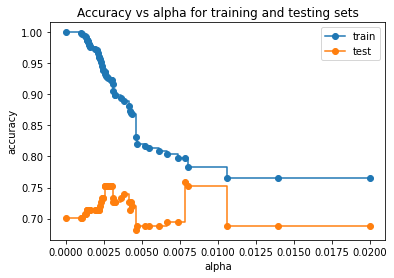

Decision tree with the best pruning : 15 nodes, 0.76 accuracy


In [25]:
# testing accuracy를 높이는 최고의 ccp_alpha는?

train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

# 가장 높은 accuracy를 보이는 ccp_alpha 값은 약 0.003
# effective alpha = 약 0.003일 때 가장 높은 성능을 가지는 sub-tree가 만들어짐

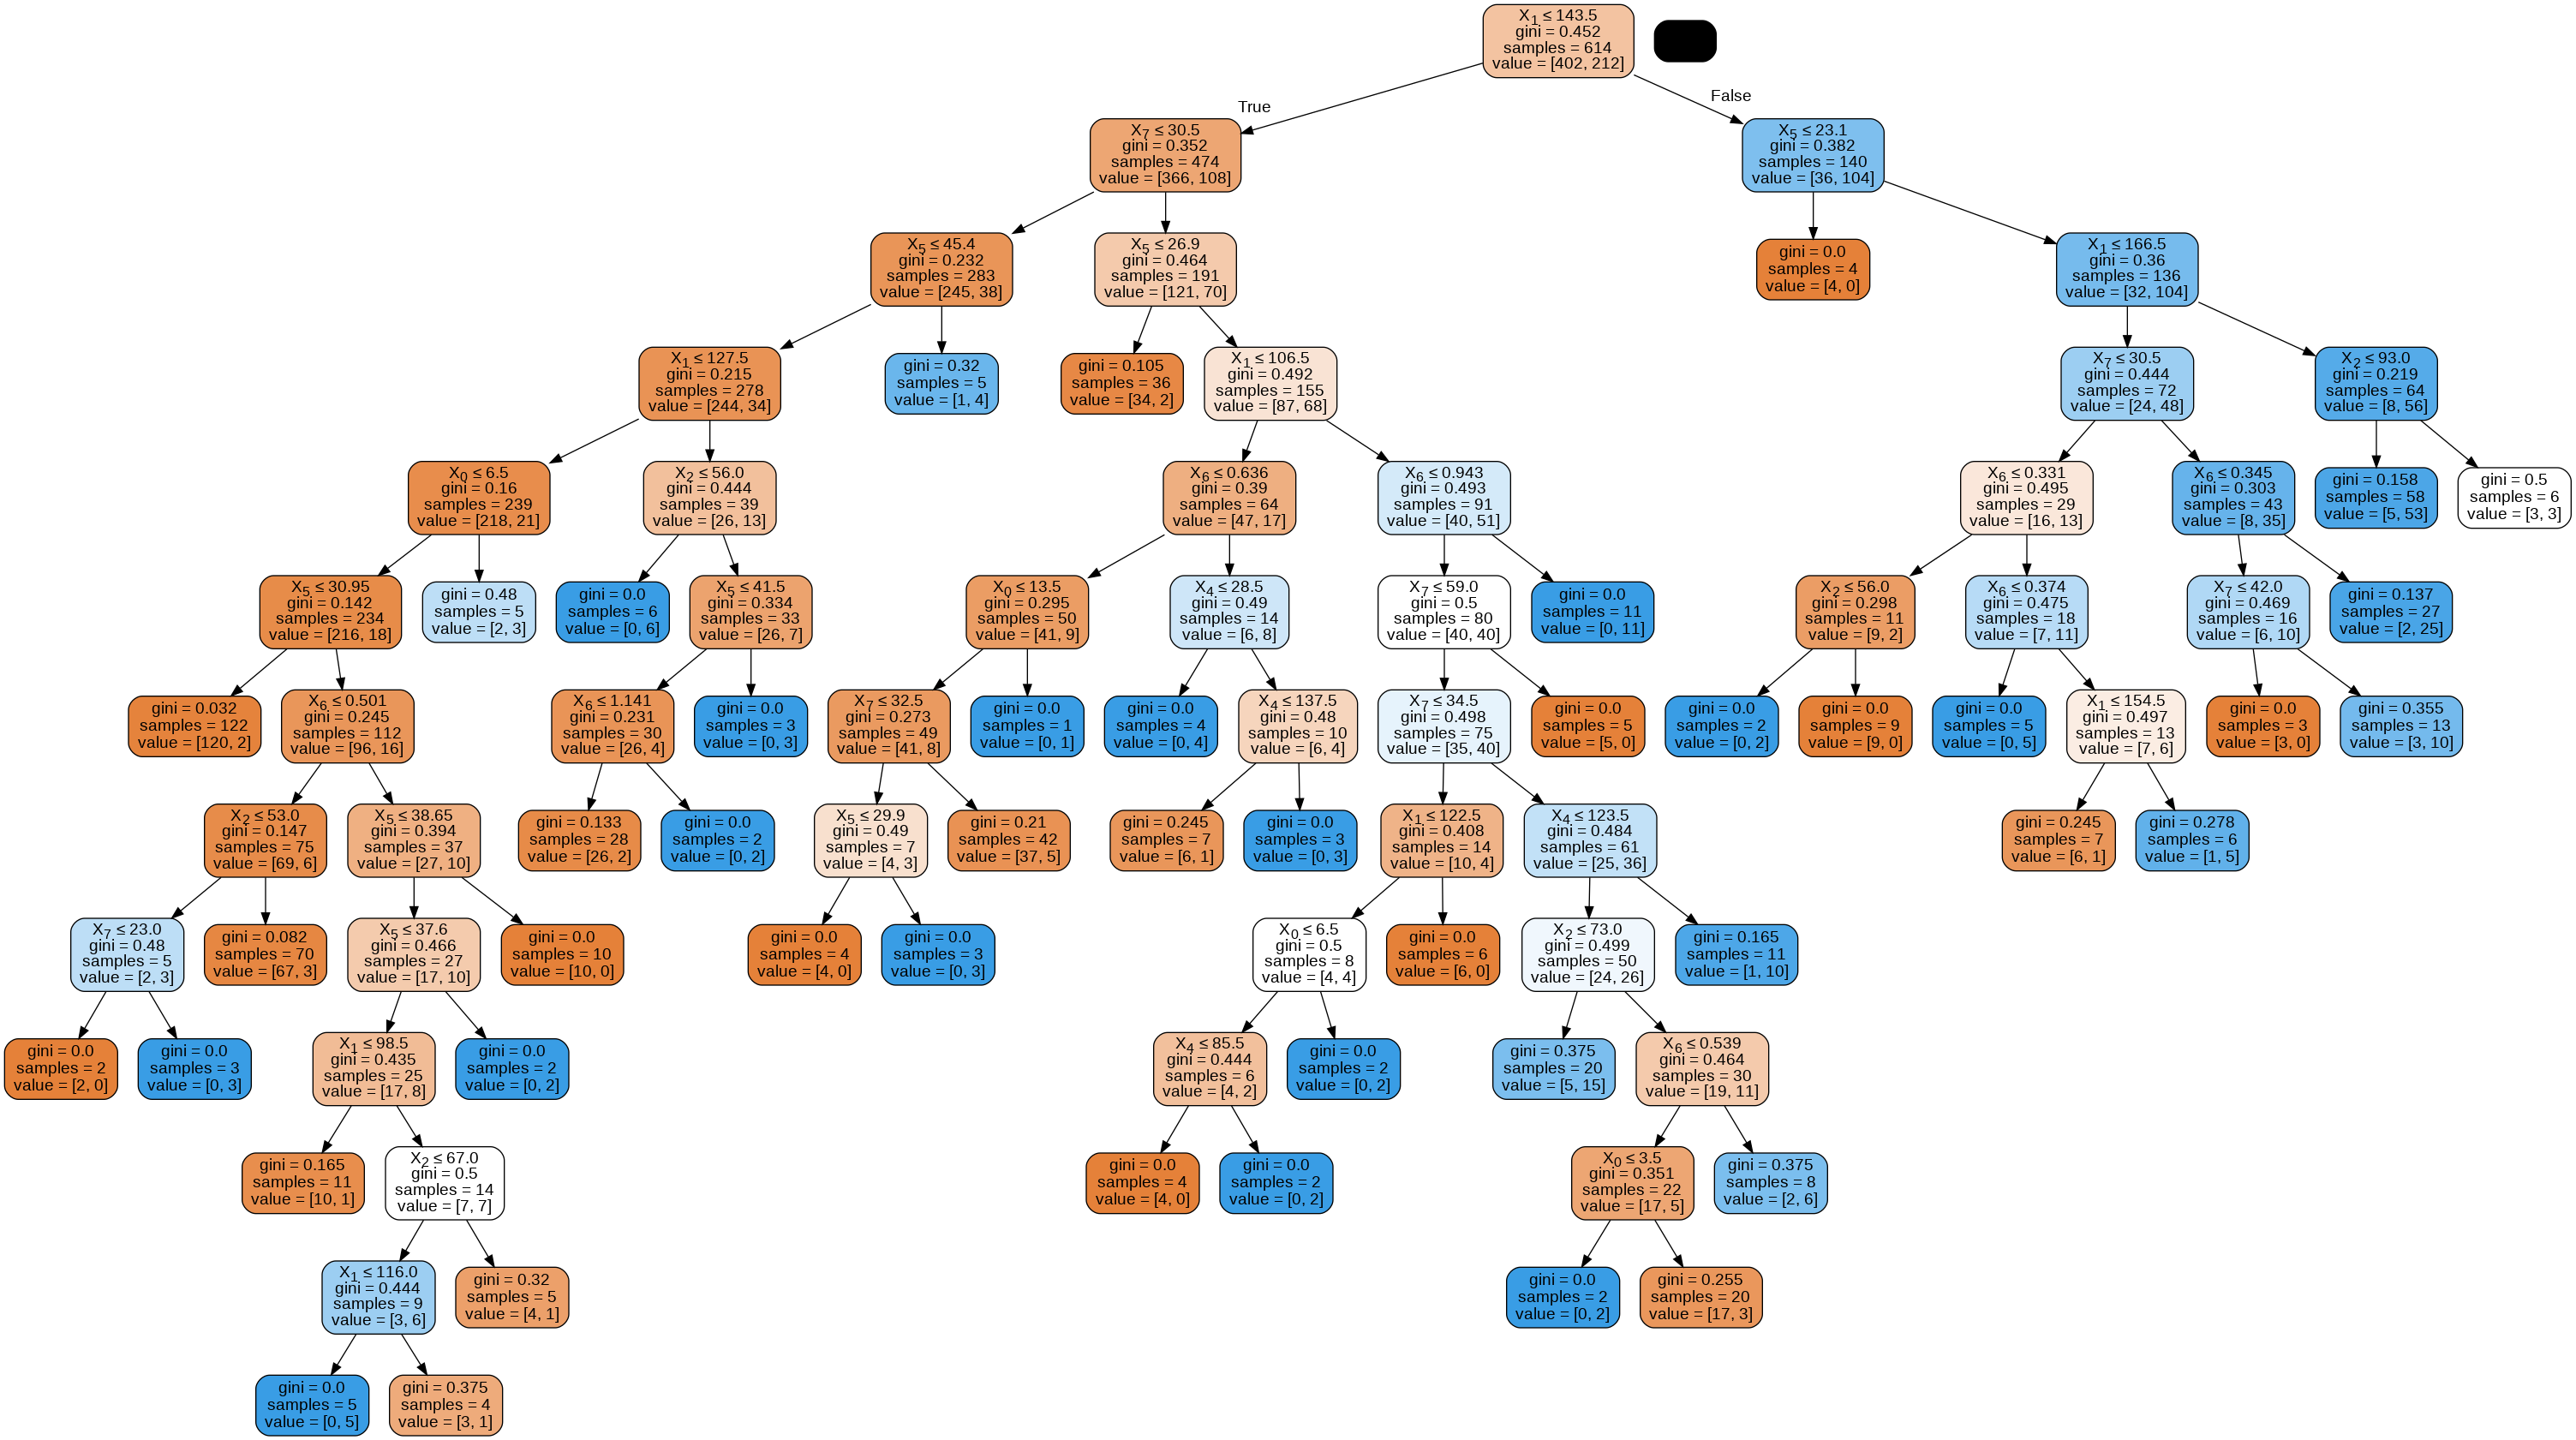

In [26]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.003)
clf = clf.fit(x_train, y_train)
draw_decision_tree(clf)

# sub-trees 중 가장 성능 좋음
# overfitting 방지되었다고 추정